In [1]:
%pylab inline
from pyspark import SparkContext, SparkConf
from pyspark.mllib.linalg.distributed import IndexedRow, IndexedRowMatrix
np.set_printoptions(precision=3, suppress=True)
import numpy as np
import pandas as pd
import os
import time

# Custom functions for the task.
from VAT import VAT
from iVAT import iVAT
from dissimilarity import dissimilarity
from clusivatSampling import clusivatSampling

start_time = time.time()

Populating the interactive namespace from numpy and matplotlib


In [2]:
# INPUTS TO ALGORITHM
clustEstimate = 20            # Initial guess of number of clusters.
sampleRatio = 1.0
metric = 'NCC'

# If checking algorithmic performance all additional printing, figure display
# options will be removed.
test_run = True
optimised = True

# Imports CSV and creates a time series.
f = "./GS/Sheet1.csv"

dateparse = lambda dates: pd.datetime.strptime(dates, '%d/%m/%Y %H:%M')

power = pd.read_csv(f, parse_dates=True, index_col='Time', 
                    date_parser=dateparse)
                    
t_ind = power.index                    
days = pd.date_range(start=min(t_ind), end=max(t_ind), freq='D')

for i in power:
    power[i] = pd.to_numeric(power[i], errors=coerce)
    
ts = [power['LOAD #2'][str(j.date())].values for j in days]
ts = np.vstack(tuple(i for i in ts if len(i) == 48))

# Array of time series data. This is a poor way of doing it because it means the series must be 
# strorable in memory before being converted to a RDD.
numSeries = len(ts)
numSamples = np.ceil(numSeries * sampleRatio)
lenSeries = len(ts[0])
lenSeriesPow2 = np.power(2,int(np.ceil(np.log2(lenSeries))))
timeSeries = [i for i in range(numSeries)]
for i in range(numSeries):
    timeSeries[i] = i, np.append(ts[i,:], np.zeros(lenSeriesPow2-lenSeries))
    
# Indicates initial setup has been performed and data loaded from file.
preprocessing_time = time.time()

In [3]:
# Partitioning component.

# This is actually not the preferred way of distributing data - as we have actually sent this data across all 
# nodes and are just waiting for it to be acted on - in practise this is wasteful.
if optimised:
    timeSeriesRDD = sc.parallelize(timeSeries,numSlices=3)
else:
    timeSeriesRDD = sc.parallelize(timeSeries)

In [4]:
# Create RDD consisting of indexed dissimilarity arrays of each time series.
# Can select 'euclidian', 'NCC', or 'DTW' as distance metric.
tsDissimRDD = dissimilarity(timeSeriesRDD,numSeries=numSeries,metric=metric)

dissim_mat_time = time.time()

In [5]:
# Downsample the RDD with given ratio and initial overestimate of cluster count.
sampleIndex, tsDissimMatrixSampled = clusivatSampling(tsDissimRDD,clustEstimate,sampleRatio,clusterCount = False)

#tsDissimMatrixFull = clusivatSampling(tsDissimRDD,clustEstimate,sampleRatio=1.0,clusterCount = False)

sample_time = time.time()

In [6]:
nanind = np.logical_not(np.isnan(tsDissimMatrixSampled[0]))
#nanind
#tsDissimMatrixSampled
tsDissimMatrixSamplednoNan = tsDissimMatrixSampled[:,nanind]
tsDissimMatrixSamplednoNan = tsDissimMatrixSamplednoNan[nanind,:]

In [7]:
D_iVAT, D_VAT, I_VAT, C, d = iVAT(tsDissimMatrixSamplednoNan)

## RESULTS

In [8]:
iVAT_develop = time.time()

pre_time = preprocessing_time - start_time
build_dissim_mat = dissim_mat_time - preprocessing_time
produce_sample_matrix = sample_time - dissim_mat_time
iVAT_development_time = iVAT_develop - sample_time
totalruntime = iVAT_develop - start_time

print("Pre-processing time = %s seconds" % pre_time)
print("Unordered dissimilarity matrix development = %s seconds" % build_dissim_mat)
print("Produce sampled matrix =  %s seconds" % produce_sample_matrix)
print("iVAT developement time =  %s seconds" % iVAT_development_time)
print("Total runtime =  %s seconds" % totalruntime)

Pre-processing time = 12.0271751881 seconds
Unordered dissimilarity matrix development = 0.960755825043 seconds
Produce sampled matrix =  345.786002159 seconds
iVAT developement time =  45.918836832 seconds
Total runtime =  404.692770004 seconds


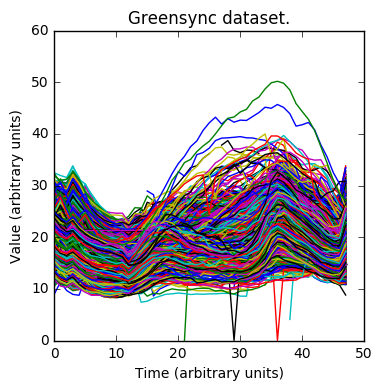

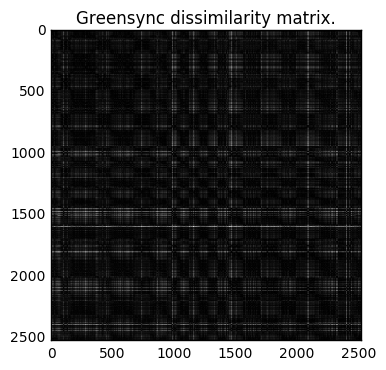

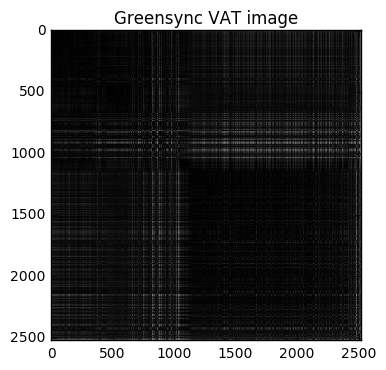

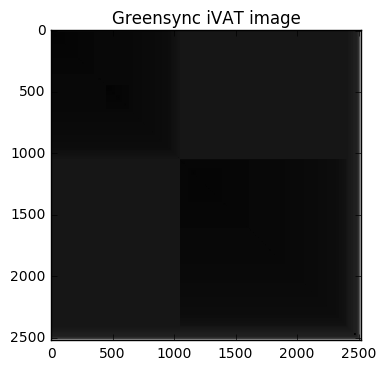

In [9]:
figure(figsize=(4,4))
for i in ts:
    plt.plot(i);
plt.xlabel('Time (arbitrary units)')
plt.ylabel('Value (arbitrary units)')
plt.title('Greensync dataset.')

figure(figsize=(4,4))
plt.imshow(tsDissimMatrixSamplednoNan,cmap='Greys_r',interpolation='none');
plt.title('Greensync dissimilarity matrix.')

figure(figsize=(4,4))
plt.imshow(D_VAT,cmap='Greys_r',interpolation='none');
plt.title('Greensync VAT image')

figure(figsize=(4,4))
plt.imshow(D_iVAT,cmap='Greys_r',interpolation='none');
plt.title('Greensync iVAT image')

In [12]:
import pickle

fl_iVAT = open('GS/latest_VAT.csv','w')
numpy.savetxt(fl_iVAT,D_iVAT,delimiter=',')
fl_iVAT.close()

fl_VAT = open('GS/latest_iVAT.csv','wb')
numpy.savetxt(fl_VAT,D_VAT,delimiter=',')
fl_VAT.close()

fl_ind = open('GS/latest_ind.pickle','wb')
pickle.dump(I_VAT,fl_ind)
fl_ind.close()

fl_sind = open('GS/latest_sind.pickle','wb')
pickle.dump(sampleIndex,fl_sind)
fl_sind.close()

fl_MSTC = open('GS/latest_MSTC.pickle','wb')
pickle.dump(C,fl_MSTC)
fl_MSTC.close()

fl_MSTd = open('GS/latest_MSTd.pickle','wb')
pickle.dump(d,fl_MSTd)
fl_MSTd.close()

fl_meta = open('GS/latest_meta.pickle','wb')
pickle.dump({'sample ratio': sampleRatio, 'metric': metric},fl_meta)
fl_meta.close()

In [13]:
fl_sind = open('GS/latest_sind.pickle','wb')
pickle.dump(nanind,fl_sind)
fl_sind.close()